## Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve


## Load Data

In [6]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded']) 

### Visualisation of Data distribution

C:\Users\Anton\AppData\Local\Temp\ipykernel_7236\81429424.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([label_mapping[x] for x in counts["daytime_encoded"]])


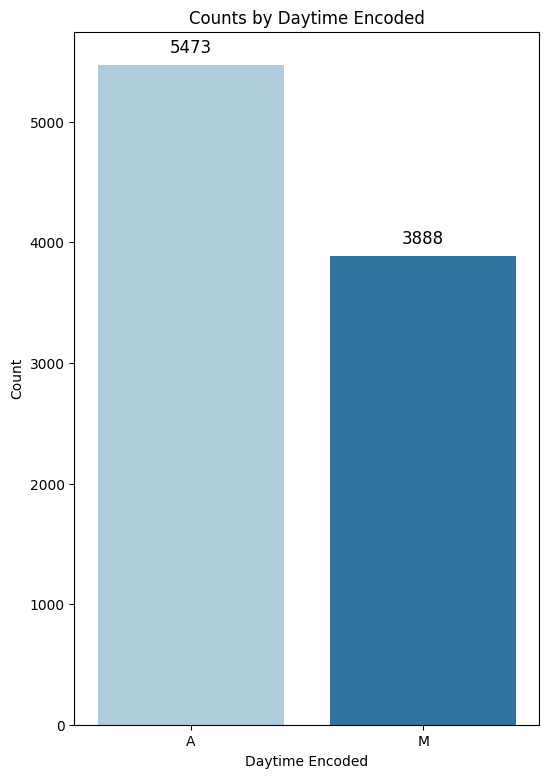

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = df['daytime_encoded'].value_counts().reset_index()
counts.columns = ['daytime_encoded', 'count']

# Farben aus "Paired"
colors = sns.color_palette("Paired", n_colors=len(counts))
label_mapping = {0: "A", 1: "M"}

# Plot erstellen
plt.figure(figsize=(6,9))
ax = sns.barplot(data=counts, x="daytime_encoded", y="count", hue="daytime_encoded", palette=colors, legend=False)

# Werte über den Balken anzeigen
for i, v in enumerate(counts["count"]):
    ax.text(i, v + 100, str(v), ha='center', fontsize=12)

ax.set_xticklabels([label_mapping[x] for x in counts["daytime_encoded"]])

# Achsentitel setzen
plt.xlabel("Daytime Encoded")
plt.ylabel("Count")
plt.title("Counts by Daytime Encoded")

plt.show()

## Data Initialization & Split

In [7]:
# set target
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


Trainingsdaten: (6552, 57), Testdaten: (2809, 57)


### Baseline Approach

In [8]:
# initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# train model
xgb_model.fit(X_train, y_train)

# results
y_pred = xgb_model.predict(X_test)

print("Training Accuracy:", xgb_model.score(X_train, y_train))
print("Test Accuracy:", xgb_model.score(X_test, y_test))


target_names = ['A', 'M']
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\xgboost\core.py:158: UserWarning: [16:06:26] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 1.0
Test Accuracy: 1.0
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00      1642
           M       1.00      1.00      1.00      1167

    accuracy                           1.00      2809
   macro avg       1.00      1.00      1.00      2809
weighted avg       1.00      1.00      1.00      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1642    0]
 [   0 1167]]
--------------------------------------------------------------------------------


XG Boost baseline model shows irregular accuracy of 100%, there is some problem. Test for overfitting or data leakage.

### Pipeline with Scaler, Cross Validation

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', XGBClassifier(  # Schritt 2: XGBoost
        random_state=42,
        eval_metric='logloss'    # Bewertungsmetrik
    ))  
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = pipeline.predict(X_test)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-Validation Accuracy Scores: [1.         0.99923722 0.99923664 0.99847328 1.        ]
Mean CV Accuracy: 0.9993894294315278

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00      1642
           M       1.00      1.00      1.00      1167

    accuracy                           1.00      2809
   macro avg       1.00      1.00      1.00      2809
weighted avg       1.00      1.00      1.00      2809


Confusion Matrix:
 [[1642    0]
 [   0 1167]]


Cross validation accuracy is close to test accuracy, both indicate overfitting.

### Learning Curve Approach

In [8]:
# initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    xgb_model,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="accuracy", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


###  Learning Curve Visualisation

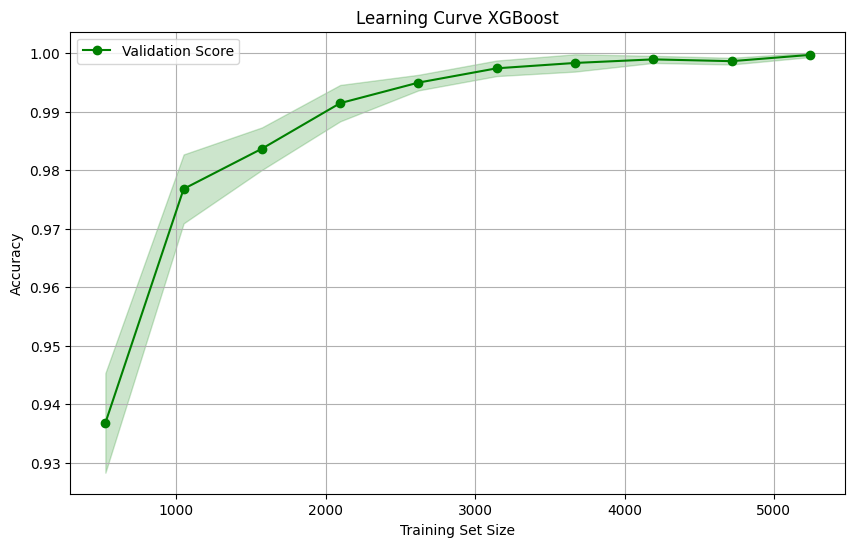

In [9]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve XGBoost")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


This approach shows, that overfitting is related to training set size, as test accuracy approaches 100% for total data input. Problem is probably mostly part of the dataset and needs to be adressed. 

### Remove features with overpowered importance from feature_importance_analysis.ipynb

In [3]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df_improved = pd.read_csv(data_path)
df_improved = df_improved.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded']) 

# drop overpowered features
common_features = pd.read_csv("FeatureSelectionForDeletion/common_features.csv") 
features_to_drop = common_features["Common Features"].tolist()
df_improved = df_improved.drop(columns=features_to_drop, errors="ignore")

# set target
target = 'daytime_encoded'  # Zielvariable
X = df_improved.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df_improved[target]  # Zielvariable

# Train test Split
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train_improved.shape}, Testdaten: {X_test_improved.shape}")
print(df_improved.columns)


Trainingsdaten: (6552, 49), Testdaten: (2809, 49)
Index(['location_encoded', 'speed_kmh_encoded', 'daytime_encoded',
       'weather_encoded', 'vehicle_encoded', 'source_direction_encoded',
       'microphone_encoded', 'channel_encoded', 'mfcc_1', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13', 'band_1_dB', 'band_2_dB', 'band_3_dB', 'band_4_dB',
       'band_5_dB', 'band_6_dB', 'band_7_dB', 'band_8_dB', 'band_9_dB',
       'band_10_dB', 'band_11_dB', 'band_12_dB', 'band_13_dB', 'band_14_dB',
       'band_15_dB', 'band_16_dB', 'band_17_dB', 'band_18_dB', 'band_19_dB',
       'band_20_dB', 'band_21_dB', 'band_22_dB', 'band_23_dB', 'band_24_dB',
       'peak_dB_1', 'peak_freq_1', 'peak_dB_2', 'peak_freq_2', 'peak_dB_3',
       'peak_freq_3', 'octband_dB_mean'],
      dtype='object')


### Feature Selected Baseline Performance 

In [13]:
# initialize model
xgb_model = XGBClassifier( eval_metric='logloss', random_state=42)

# train model
xgb_model.fit(X_train_improved, y_train_improved)

# results
y_pred_improved = xgb_model.predict(X_test_improved)

target_names = ['A', 'M']

print("Training Accuracy:", xgb_model.score(X_train_improved, y_train_improved))
print("Test Accuracy:", xgb_model.score(X_test_improved, y_test_improved))

print('-'*80)

print("\nClassification Report:\n", classification_report(y_test_improved, y_pred_improved, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test_improved, y_pred_improved))
print('-'*80)

c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\xgboost\core.py:158: UserWarning: [17:33:47] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 1.0
Test Accuracy: 0.9252402990388039
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.93      0.94      0.94      1642
           M       0.92      0.90      0.91      1167

    accuracy                           0.93      2809
   macro avg       0.92      0.92      0.92      2809
weighted avg       0.93      0.93      0.93      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1551   91]
 [ 119 1048]]
--------------------------------------------------------------------------------


There is still overfitting in the trining process. But generalization is better already due to normal test accuracy value.

### Feature Selcted Pipeline with Scaler & Crossvalidation

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', XGBClassifier(  # Schritt 2: XGBoost
        random_state=42,
        eval_metric='logloss'    # Bewertungsmetrik
    ))  
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train_improved, y_train_improved, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train_improved, y_train_improved)

# Vorhersagen auf den Testdaten
y_pred_improved = pipeline.predict(X_test_improved)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_improved, y_pred_improved))

Cross-Validation Accuracy Scores: [0.92448513 0.91151793 0.91068702 0.91526718 0.91374046]
Mean CV Accuracy: 0.9151395415189152

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.93      0.94      0.94      1642
           M       0.92      0.90      0.91      1167

    accuracy                           0.93      2809
   macro avg       0.92      0.92      0.92      2809
weighted avg       0.93      0.93      0.93      2809


Confusion Matrix:
 [[1551   91]
 [ 119 1048]]


Validation fold (0.9137) is slightly worse than trainings folds, which indicates no overfitting. In general accuracy is slightly worse than before. Indicates less overfitting.

### Hyperparameter tuning with grid search

In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_score


# Pipeline mit StandardScaler und XGBClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', XGBClassifier( eval_metric='logloss', random_state=42))  # Schritt 2: XGBoost
])

# Hyperparameter für GridSearch
param_grid = {
    'classifier__n_estimators': [50, 100, 150],       # Anzahl der Bäume
    'classifier__max_depth': [3, 5, 7],              # Maximale Tiefe der Bäume
    'classifier__learning_rate': [0.01, 0.1, 0.2],   # Lernrate
    'classifier__subsample': [0.8, 1.0],             # Anteil der Stichprobe für jeden Baum
    'classifier__colsample_bytree': [0.8, 1.0],      # Anteil der Spalten pro Baum
}

# GridSearchCV mit Cross-Validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                         # Anzahl der Cross-Validation-Folds
    scoring='accuracy',           # Metrik zur Bewertung
    n_jobs=-1,                    # Parallelisierung
    verbose=2                     # Fortschrittsanzeige
)

# GridSearchCV auf die verbesserten Trainingsdaten anwenden
grid_search.fit(X_train_improved, y_train_improved)

# Beste Hyperparameter und Ergebnis anzeigen
print("Beste Hyperparameter:", grid_search.best_params_)
print("Beste Cross-Validation-Genauigkeit:", grid_search.best_score_)

# Pipeline mit den besten Parametern trainieren
best_pipeline = grid_search.best_estimator_

# Vorhersagen auf den verbesserten Testdaten
y_pred_improved = best_pipeline.predict(X_test_improved)

# Ergebnisse auf den verbesserten Testdaten ausgeben
target_names = ['A', 'M']  # Klassenbezeichnungen anpassen
print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names=target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_improved, y_pred_improved))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:26] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Beste Hyperparameter: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Beste Cross-Validation-Genauigkeit: 0.9198705026755404

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.92      0.95      0.93      1642
           M       0.92      0.89      0.90      1167

    accuracy                           0.92      2809
   macro avg       0.92      0.92      0.92      2809
weighted avg       0.92      0.92      0.92      2809


Confusion Matrix:
 [[1554   88]
 [ 130 1037]]


### Model test with optimal hyperparameters and improved feature selection

Cross-Validation Accuracy Scores: [0.92906178 0.91914569 0.91603053 0.91984733 0.91526718]
Mean CV Accuracy: 0.9198705026755404
Standard Deviation CV Accuracy: 0.0049181609579249715
AUC: 0.9782

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.92      0.95      0.93      1642
           M       0.92      0.89      0.90      1167

    accuracy                           0.92      2809
   macro avg       0.92      0.92      0.92      2809
weighted avg       0.92      0.92      0.92      2809


Confusion Matrix:
 [[1554   88]
 [ 130 1037]]


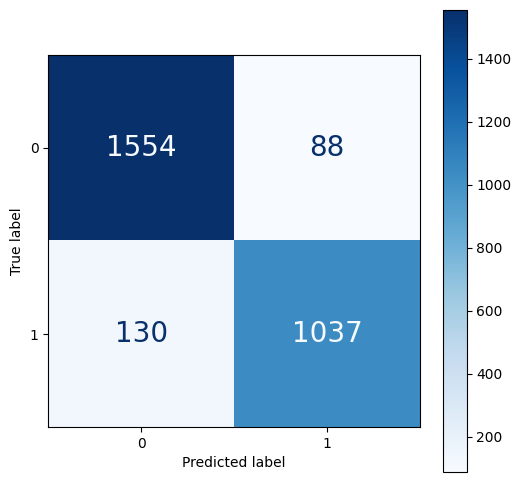

In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', XGBClassifier(  # Schritt 2: XGBoost
        colsample_bytree=1.0,       # Anteil der Spalten pro Baum
        gamma=0.2,                  # Mindestverlustreduktion, um einen Split zu machen
        learning_rate=0.2,          # Lernrate
        max_depth=5,                # Maximale Tiefe der Bäume
        n_estimators=100,           # Anzahl der Bäume
        subsample=0.8,              # Anteil der Stichprobe für jeden Baum
        eval_metric='logloss',      # Verwendetes Evaluierungsmaß
        random_state=42             # Reproduzierbarkeit
    ))  
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train_improved, y_train_improved, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train_improved, y_train_improved)

# Vorhersagen auf den Testdaten
y_pred_improved = pipeline.predict(X_test_improved)
y_probs = pipeline.predict_proba(X_test_improved)[:, 1]

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Standard Deviation CV Accuracy:", np.std(cv_scores))
auc = roc_auc_score(y_test_improved, y_probs)
print(f"AUC: {auc:.4f}")

print("\nTestdaten-Auswertung:")
print(classification_report(y_test_improved, y_pred_improved, target_names= target_names))
matrix = confusion_matrix(y_test_improved, y_pred_improved)
print("\nConfusion Matrix:\n",matrix )
display_cm_logreg = ConfusionMatrixDisplay(matrix)
fig, ax = plt.subplots(figsize=(6, 6))  # Größe des Plots anpassen
display_cm_logreg.plot(ax=ax, text_kw={"fontsize": 20}, cmap=plt.cm.Blues)  # Schriftgröße anpassen
plt.show()

### Determine most important features

In [5]:

# Feature-Importances abrufen
importance = pipeline.named_steps['classifier'].feature_importances_

# Features mit ihren Importances kombinieren
feature_names = X_train_improved.columns  # Falls X_train ein DataFrame ist
feature_importance_dict = dict(zip(feature_names, importance))

# Nach Importance sortieren und die Top 3 auswählen
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:3]

# Ausgabe der 3 wichtigsten Features
print("Top 3 wichtigste Features:")
for feature, value in top_features:
    print(f"{feature}: {value:.4f}")


Top 3 wichtigste Features:
speed_kmh_encoded: 0.1515
weather_encoded: 0.0865
channel_encoded: 0.0708


### ROC Visualisation

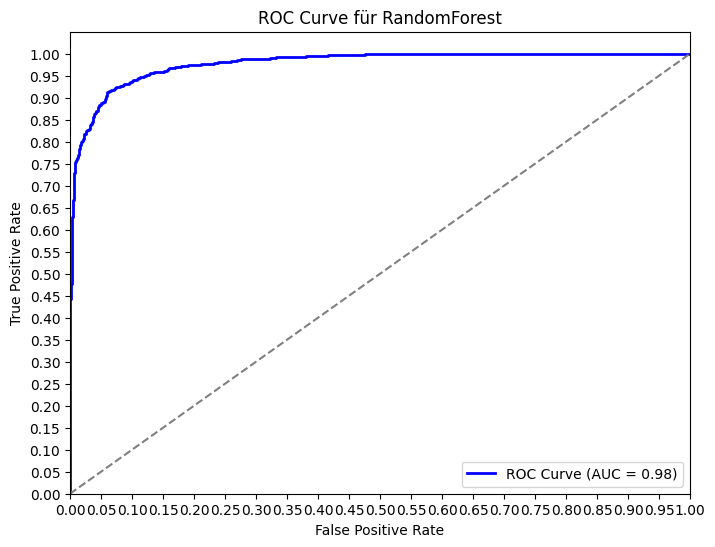

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Wahrscheinlichkeiten für die positive Klasse (M) vorhersagen
y_probs_improved = pipeline.predict_proba(X_test_improved)[:, 1]  # Nur Spalte für Klasse 1 (M)

# ROC-Kurve berechnen
fpr, tpr, thresholds = roc_curve(y_test_improved, y_probs_improved)

# AUC berechnen
auc_score = roc_auc_score(y_test_improved, y_probs_improved)

# ROC-Kurve plotten
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale Linie für Zufallsrate
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Achsenbeschriftungen feinkörniger setzen
plt.xticks(np.arange(0.0, 1.05, 0.05))  # Schritte von 0.05 für X-Achse
plt.yticks(np.arange(0.0, 1.05, 0.05))  # Schritte von 0.05 für Y-Achse

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve für RandomForest')
plt.legend(loc='lower right')
plt.show()
